In [102]:
### IMPORTAZIONI ###

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
import os

In [103]:
### VALORI ###

LATENT_DIM = 32
IMG_CHANNELS = 3
IMG_SIZE = 64
DATASET_PATH = 'C:/Users/Simone/OneDrive/Desktop/GAN_IMG_GEN_CATS/mincat'
BATCH_SIZE = 64  #64
N_EPOCHS = 400
LEARNING_RATE = 0.0002
SAMPLE_INTERVAL = 400
MODEL_SAVE_INTERVAL = 5

In [104]:
### CARTELLA SALVATAGGIO MODELLI ###

# Cartella per salvare i modelli
MODEL_SAVE_PATH = 'models/'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)


In [105]:
### CARICA DATASET ###

# Dataset personalizzato per immagini senza sottocartelle
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # Restituiamo 0 come target di default

# Trasformazioni
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * IMG_CHANNELS, [0.5] * IMG_CHANNELS)
])

# Caricamento del dataset
dataset = CustomImageDataset(root_dir=DATASET_PATH, transform=transform)

# Usare più workers per il DataLoader (aumenta la velocità di caricamento)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

In [106]:
### GENERATORE ###

# Implementazione del Generatore e Discriminatore
class EfficientGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(EfficientGenerator, self).__init__()
        self.init_size = IMG_SIZE // 16
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, IMG_CHANNELS, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [107]:
### DISCRIMINATORE ###

class EfficientDiscriminator(nn.Module):
    def __init__(self):
        super(EfficientDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(IMG_CHANNELS, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = IMG_SIZE // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [108]:
### INIZIALIZZAZIONE ###

# Inizializza i modelli
generator = EfficientGenerator(LATENT_DIM)
discriminator = EfficientDiscriminator()

# Funzione per inizializzare i pesi
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


In [109]:
### PESI ###

# Inizializza i pesi
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Utilizzo della GPU se disponibile
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

# Ottimizzatori e funzione di perdita
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
adversarial_loss = nn.BCEWithLogitsLoss().to(device)


In [110]:
### ALTRE FUNZIONI ###

# Funzione per visualizzare l'immagine generata
def show_generated_image(epoch):
    z = torch.randn(1, LATENT_DIM, device=device)
    gen_img = generator(z).detach().cpu()
    save_image(gen_img, f"generated_image_epoch_{epoch}.png", normalize=True)
    plt.imshow(gen_img.permute(0, 2, 3, 1).squeeze())
    plt.axis('off')
    plt.show()

# Funzione per salvare il modello
def save_model(epoch):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict()
    }, f"{MODEL_SAVE_PATH}gan_model_epoch_{epoch}.pth")
    print(f"Modelli salvati per l'epoca {epoch}")

# Funzione per caricare un modello
def load_model(epoch):
    checkpoint = torch.load(f"{MODEL_SAVE_PATH}gan_model_epoch_{epoch}.pth")
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    print(f"Modelli caricati per l'epoca {epoch}")

# Funzione per generare immagini usando un modello caricato
def generate_images(epoch):
    load_model(epoch)  # Carica il modello
    generator.eval()  # Imposta il generatore in modalità di valutazione
    with torch.no_grad():
        for i in range(5):  # Genera 5 immagini
            z = torch.randn(1, LATENT_DIM, device=device)
            gen_img = generator(z).detach().cpu()
            save_image(gen_img, f"generated_image_epoch_{epoch}_{i}.png", normalize=True)
            plt.imshow(gen_img.permute(0, 2, 3, 1).squeeze())
            plt.axis('off')
            plt.show()

C:\Users\Simone\AppData\Local\Temp\ipykernel_19812\2162817467.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{MODEL_SAVE_PATH}gan_model_epoch

Modelli caricati per l'epoca 281


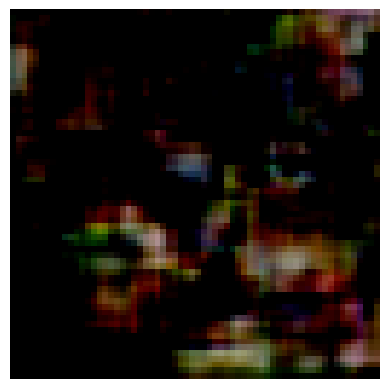

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


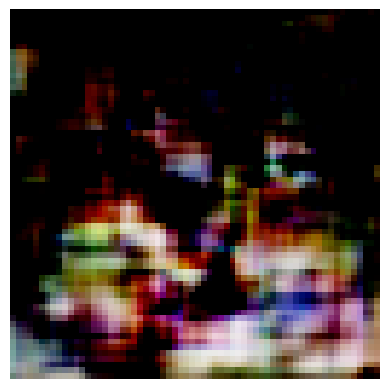

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


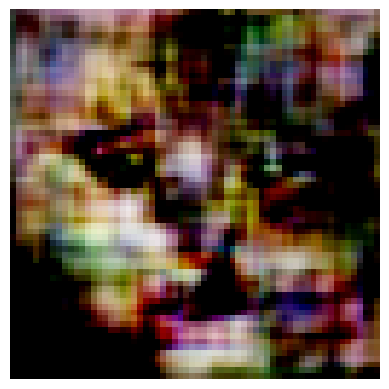

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


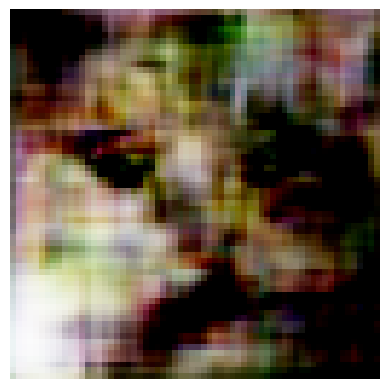

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


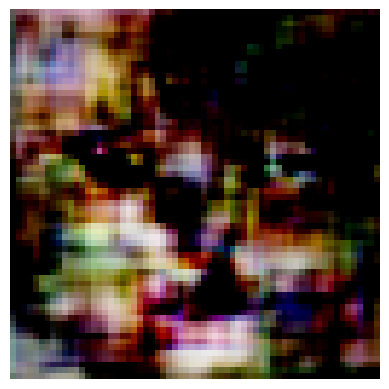

In [116]:
### GENERA IMMAGINI DA MODELLO ###
##################################

generate_images(epoch=281)

In [112]:
### ADDESTRA UN NUOVO MODELLO ###
#################################

# for epoch in range(N_EPOCHS):
#     for i, (imgs, _) in enumerate(dataloader):
        
#         valid = torch.ones((imgs.size(0), 1), device=device, requires_grad=False)
#         fake = torch.zeros((imgs.size(0), 1), device=device, requires_grad=False)

#         real_imgs = imgs.to(device)

#         z = torch.randn((imgs.size(0), LATENT_DIM), device=device)
#         gen_imgs = generator(z)

#         # Allenamento del Discriminatore
#         optimizer_D.zero_grad()
#         real_loss = adversarial_loss(discriminator(real_imgs), valid)
#         fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
#         d_loss = (real_loss + fake_loss) / 2
#         d_loss.backward()
#         optimizer_D.step()

#         # Allenamento del Generatore
#         optimizer_G.zero_grad()
#         g_loss = adversarial_loss(discriminator(gen_imgs), valid)
#         g_loss.backward()
#         optimizer_G.step()

#         # Stampa i risultati a intervalli regolari
#         if i % SAMPLE_INTERVAL == 0:
#             print(f"[Epoch {epoch}/{N_EPOCHS}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
#     # Visualizza l'immagine generata e salva il modello ogni 5 epoche
#     if epoch % 1 == 0:
#         show_generated_image(epoch)
#         save_model(epoch)


In [ ]:
### CONTINUA ADDESTRAMENTO ###
##############################

N_EPOCHS_continuare = 195

def load_checkpoint(filepath):
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint caricato. Riprendo l'addestramento dall'epoca {start_epoch}.")
        return start_epoch
    else:
        print("Checkpoint non trovato. Inizio addestramento da zero.")
        return 0

# Carica il checkpoint se esiste
checkpoint_path = f"{MODEL_SAVE_PATH}gan_model_epoch_{N_EPOCHS_continuare}.pth"
start_epoch = load_checkpoint(checkpoint_path)

# Training Loop modificato
for epoch in range(start_epoch, N_EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        
        valid = torch.ones((imgs.size(0), 1), device=device, requires_grad=False)
        fake = torch.zeros((imgs.size(0), 1), device=device, requires_grad=False)

        real_imgs = imgs.to(device)

        z = torch.randn((imgs.size(0), LATENT_DIM), device=device)
        gen_imgs = generator(z)

        # Allenamento del Discriminatore
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Allenamento del Generatore
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Stampa i risultati a intervalli regolari
        if i % SAMPLE_INTERVAL == 0:
            print(f"[Epoch {epoch}/{N_EPOCHS}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    # Visualizza l'immagine generata e salva il modello ogni epoca
    if epoch % 1 == 0:
        show_generated_image(epoch)
        save_model(epoch)